# GreenMining Experiment: 

This notebook demonstrates a complete analysis pipeline using the `greenmining` library.

## Experiment Setup
- **10 android repositories** found via GraphQL search
- **5 manually selected repositories** (FastAPI, UPISAS, Green-lab, Experiment-runner, Requests)
- **Total: 15 repositories** — all analyzed with the same pipeline and ALL features enabled
- **Commits per repository:** 50
- **Min stars:** 1
- **Languages:** Top 20 programming languages

## Pipeline Structure
1. **Data Gathering** — search + URL-based fetching for all 15 repos
2. **Analysis** — every feature applied to every repo equally

In [1]:
%pip install greenmining[energy] --quiet

Note: you may need to restart the kernel to use updated packages.


## Step 1: Import Libraries

Import all GreenMining modules needed for the experiment.

In [2]:
import os
import json
import time
import tracemalloc
import pandas as pd

import greenmining
from greenmining import (
    fetch_repositories,
    clone_repositories,
    analyze_repositories,
    GSF_PATTERNS,
    GREEN_KEYWORDS,
    is_green_aware,
    get_pattern_by_keywords,
)
from greenmining.analyzers import (
    StatisticalAnalyzer,
    TemporalAnalyzer,
    CodeDiffAnalyzer,
    MetricsPowerCorrelator,
)
from greenmining.energy import get_energy_meter, CPUEnergyMeter

print(f"GreenMining version: {greenmining.__version__}")
print(f"GSF Patterns: {len(GSF_PATTERNS)}")
print(f"Green Keywords: {len(GREEN_KEYWORDS)}")

GreenMining version: 1.2.5
GSF Patterns: 124
Green Keywords: 332


## Step 2: Configuration

GitHub token and analysis parameters shared across all repositories.

In [3]:
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN", "your_github_token_here")

try:
    from dotenv import load_dotenv

    load_dotenv()
    GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN", GITHUB_TOKEN)
except ImportError:
    pass

if GITHUB_TOKEN == "your_github_token_here":
    print("WARNING: Set GITHUB_TOKEN to run the search step.")
else:
    print(f"GitHub token configured ({GITHUB_TOKEN[:8]}...)")

# Shared analysis parameters
MAX_COMMITS = 10
MIN_STARS = 5
PARALLEL_WORKERS = 10

# Date filters for repository search
CREATED_AFTER = "2020-01-01"
CREATED_BEFORE = "2026-12-31"
PUSHED_AFTER = "2020-01-01"

# Date filters for commit analysis
COMMIT_DATE_FROM = "2020-01-01"
COMMIT_DATE_TO = "2026-12-31"

LANGUAGES = [
    "Python",
    "JavaScript",
    "TypeScript",
    "Java",
    "C++",
    "Shell",
    "C#",
    "Go",
    "Rust",
    "PHP",
    "Ruby",
    "Swift",
    "Kotlin",
    "Scala",
    "R",
    "MATLAB",
    "Dart",
    "Lua",
    "Perl",
    "Haskell",
    "Elixir",
]

print(f"Max commits per repo: {MAX_COMMITS}")
print(f"Min stars: {MIN_STARS}")
print(f"Languages: {len(LANGUAGES)}")
print(f"Repo created: {CREATED_AFTER} to {CREATED_BEFORE}")
print(f"Repo pushed after: {PUSHED_AFTER}")
print(f"Commit date range: {COMMIT_DATE_FROM} to {COMMIT_DATE_TO}")

GitHub token configured (github_p...)
Max commits per repo: 10
Min stars: 5
Languages: 21
Repo created: 2020-01-01 to 2026-12-31
Repo pushed after: 2020-01-01
Commit date range: 2020-01-01 to 2026-12-31


---
## Step 3: Search Repositories

Use the GraphQL API to find 10 android repositories matching our criteria.

In [4]:
search_repos = fetch_repositories(
    github_token=GITHUB_TOKEN,
    max_repos=5,
    min_stars=MIN_STARS,
    languages=LANGUAGES,
    keywords="mobile app",
    created_after=CREATED_AFTER,
    created_before=CREATED_BEFORE,
    pushed_after=PUSHED_AFTER,
)

print(f"Found {len(search_repos)} mobile app repositories:")
for i, repo in enumerate(search_repos, 1):
    print(f"  {i:2d}. {repo.full_name} ({repo.stars} stars, {repo.language})")

search_urls = [repo.url for repo in search_repos]

Fetching up to 5 repositories...
   Keywords: mobile app
   Filters: min_stars=5
   Created: 2020-01-01 to 2026-12-31
   Pushed: 2020-01-01 to any
GraphQL Search Query: mobile app stars:>=5 created:>=2020-01-01 created:<=2026-12-31 pushed:>=2020-01-01
Rate Limit: 4997/5000 (cost: 1)
Fetched 5 repositories using GraphQL
Fetched 5 repositories
   Saved to: data/repositories.json
Found 5 mobile app repositories:
   1. lichess-org/mobile (2059 stars, Dart)
   2. xbrowsersync/app (1675 stars, TypeScript)
   3. tanprathan/MobileApp-Pentest-Cheatsheet (5140 stars, None)
   4. ant-design/ant-design-mobile (11954 stars, TypeScript)
   5. frappe/mobile (265 stars, Dart)


## Step 4: Fetching Repositories

In [5]:
# 3 manually selected repositories
manual_urls = [
    "https://github.com/S2-group/green-lab",
    "https://github.com/S2-group/UPISAS",
    "https://github.com/S2-group/experiment-runner",
    "https://github.com/S2-group/robot-runner",
    "https://github.com/S2-group/android-runner",
]

# Combine all URLs
all_urls = search_urls + manual_urls
print(f"Total repositories: {len(all_urls)}")
print(f"Search results: {len(search_urls)}")
print(f"Manual selection: {len(manual_urls)}")
print(f"Commit date range: {COMMIT_DATE_FROM} to {COMMIT_DATE_TO}")
print()

Total repositories: 10
Search results: 5
Manual selection: 5
Commit date range: 2020-01-01 to 2026-12-31



## Step 5: Analyze Repositories

Combine the 5 search results with 5 manually selected repositories, then run the
full analysis pipeline on all of them at once with every feature enabled:
- GSF pattern detection (124 patterns, 332 keywords)
- Process metrics (DMM size, complexity, interfacing)
- Method-level analysis (per-function complexity metrics)
- Source code capture (before/after for each modified file)
- Energy measurement (CPU-based tracking during analysis)

In [6]:
# Analyze ALL repositories with ALL features
raw_results = analyze_repositories(
    urls=all_urls,
    max_commits=MAX_COMMITS,
    parallel_workers=PARALLEL_WORKERS,
    output_format="dict",
    energy_tracking=True,
    energy_backend="auto",
    method_level_analysis=True,
    include_source_code=False,
    github_token=GITHUB_TOKEN,
    since_date=COMMIT_DATE_FROM,
    to_date=COMMIT_DATE_TO,
    cleanup_after=False,
    skip_merges=True,
)

# Convert dataclass results to dicts
results = [r.to_dict() for r in raw_results]

print(f"\nAnalysis complete: {len(results)} repositories")


 Analyzing 10 repositories with 10 workers

 Analyzing repository: lichess-org/mobile

 Analyzing repository: xbrowsersync/app
 Analyzing repository: tanprathan/MobileApp-Pentest-Cheatsheet

 Analyzing repository: ant-design/ant-design-mobile   Cloning to: /home/neo/Documents/greenmining/experiment/beta/greenmining_repos/lichess-org_mobile/mobile


 Analyzing repository: frappe/mobile
 Analyzing repository: S2-group/green-lab

 Analyzing repository: S2-group/UPISAS   Cloning to: /home/neo/Documents/greenmining/experiment/beta/greenmining_repos/xbrowsersync_app/app


 Analyzing repository: S2-group/experiment-runner


 Analyzing repository: S2-group/robot-runner   Cloning to: /home/neo/Documents/greenmining/experiment/beta/greenmining_repos/ant-design_ant-design-mobile/ant-design-mobile   Cloning to: /home/neo/Documents/greenmining/experiment/beta/greenmining_repos/s2-group_green-lab/green-lab
 Analyzing repository: S2-group/android-runner




   Cloning to: /home/neo/Documents/greenmi

---
## Step 6: Results Overview

Summary of the analysis across all repositories.

In [7]:
total_commits = sum(r["total_commits"] for r in results)
total_green = sum(r["green_commits"] for r in results)
overall_rate = total_green / total_commits if total_commits > 0 else 0

print("=" * 70)
print("ANALYSIS SUMMARY")
print("=" * 70)
print(f"Repositories analyzed: {len(results)}")
print(f"Total commits: {total_commits}")
print(f"Green-aware commits: {total_green}")
print(f"Overall green rate: {overall_rate:.1%}")
print()
print(f"{'Repository':<40} {'Commits':<10} {'Green':<10} {'Rate':<10}")
print("-" * 70)
for r in results:
    rate = r["green_commit_rate"] if r["total_commits"] > 0 else 0
    print(f"{r['name']:<40} {r['total_commits']:<10} {r['green_commits']:<10} {rate:.1%}")

# Build commit list for use in all later analysis steps
all_commits = []
for r in results:
    for c in r.get("commits", []):
        c["repository"] = r["name"]
        all_commits.append(c)

print(f"\nAll Commits: {len(all_commits)} commits")

ANALYSIS SUMMARY
Repositories analyzed: 10
Total commits: 100
Green-aware commits: 20
Overall green rate: 20.0%

Repository                               Commits    Green      Rate      
----------------------------------------------------------------------
S2-group/UPISAS                          10         3          30.0%
tanprathan/MobileApp-Pentest-Cheatsheet  10         0          0.0%
S2-group/experiment-runner               10         2          20.0%
frappe/mobile                            10         6          60.0%
S2-group/robot-runner                    10         4          40.0%
S2-group/android-runner                  10         1          10.0%
xbrowsersync/app                         10         2          20.0%
S2-group/green-lab                       10         0          0.0%
ant-design/ant-design-mobile             10         2          20.0%
lichess-org/mobile                       10         0          0.0%

All Commits: 100 commits


---
## Step 7: GSF Pattern Analysis

Examine the Green Software Foundation patterns detected across all repositories.
GreenMining detects 124 patterns across 15 categories with 332 keywords.

In [8]:
# Pattern frequency across all commits
pattern_counts = {}
for commit in all_commits:
    for pattern in commit.get("gsf_patterns_matched", []):
        pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

sorted_patterns = sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)

print(f"Unique patterns detected: {len(sorted_patterns)}")
print(f"\nTop 20 GSF Patterns:")
print(f"{'Pattern':<45} {'Count':<8} {'% of Commits':<12}")
print("-" * 65)
for pattern, count in sorted_patterns[:20]:
    pct = count / len(all_commits) * 100 if all_commits else 0
    print(f"{pattern:<45} {count:<8} {pct:.1f}%")

# Pattern categories
categories = set()
for p in GSF_PATTERNS.values():
    categories.add(p.get("category", "Unknown"))
print(f"\nGSF Categories ({len(categories)}):")
for cat in sorted(categories):
    count = sum(1 for p in GSF_PATTERNS.values() if p.get("category") == cat)
    print(f"  {cat}: {count} patterns")

Unique patterns detected: 30

Top 20 GSF Patterns:
Pattern                                       Count    % of Commits
-----------------------------------------------------------------
Delete Unused Storage Resources               11       11.0%
Remove Unused Assets                          11       11.0%
Avoid Excessive DOM Size                      4        4.0%
Database Views & Materialized Views           3        3.0%
Use Serverless                                2        2.0%
Match VM Utilization Requirements             2        2.0%
Enable Text Compression                       2        2.0%
Scale Down Unused Applications                2        2.0%
Properly Sized Images                         2        2.0%
Cache Static Data                             1        1.0%
Resource Limits & Constraints                 1        1.0%
Avoid Chaining Critical Requests              1        1.0%
Keep Request Counts Low                       1        1.0%
Performance Profiling            

---
## Step 8: Process Metrics

Examine the process metrics collected during analysis: DMM (Delta Maintainability Model)
scores for size, complexity, and interfacing, plus structural complexity metrics
and method-level analysis via Lizard integration.

In [9]:
print("Process Metrics Summary")
print("=" * 70)

metrics_keys = [
    "dmm_unit_size",
    "dmm_unit_complexity",
    "dmm_unit_interfacing",
    "total_nloc",
    "total_complexity",
    "max_complexity",
    "methods_count",
    "insertions",
    "deletions",
]

metrics_data = {k: [] for k in metrics_keys}
for commit in all_commits:
    for key in metrics_keys:
        val = commit.get(key)
        if val is not None:
            metrics_data[key].append(val)

print(f"{'Metric':<25} {'Avg':>10} {'Min':>10} {'Max':>10} {'N':>6}")
print("-" * 65)
for metric, values in metrics_data.items():
    if values:
        avg = sum(values) / len(values)
        print(
            f"{metric:<25} {avg:>10.2f} {min(values):>10.2f} {max(values):>10.2f} {len(values):>6}"
        )

# Method-level analysis
total_methods = sum(len(c.get("methods", [])) for c in all_commits)
print(f"\nMethod-Level Analysis:")
print(f"  Total methods analyzed: {total_methods}")

for commit in all_commits:
    methods = commit.get("methods", [])
    if methods:
        print(f"  Sample from {commit.get('repository')} ({commit['commit_hash'][:8]}):")
        for m in methods[:3]:
            print(
                f"    {m.get('name', 'N/A')}: nloc={m.get('nloc', 0)}, "
                f"complexity={m.get('complexity', 0)}"
            )
        break

# Source code changes
total_src = sum(len(c.get("source_changes", [])) for c in all_commits)
print(f"\nSource code changes captured: {total_src}")

Process Metrics Summary
Metric                           Avg        Min        Max      N
-----------------------------------------------------------------
dmm_unit_size                   0.52       0.00       1.00     30
dmm_unit_complexity             0.59       0.00       1.00     30
dmm_unit_interfacing            0.71       0.00       1.00     30
total_nloc                    507.45       0.00    8728.00    100
total_complexity              112.76       0.00    2167.00    100
max_complexity                 52.21       0.00     521.00    100
methods_count                  56.37       0.00    1115.00    100
insertions                    286.76       0.00    8845.00    100
deletions                     133.52       0.00    7405.00    100

Method-Level Analysis:
  Total methods analyzed: 5637
  Sample from S2-group/UPISAS (2d4bfdcc):
    (anonymous): nloc=6, complexity=1
    (anonymous): nloc=8, complexity=4
    (anonymous): nloc=42, complexity=1

Source code changes captured: 0


---
## Step 9: Statistical Analysis

Apply statistical methods to the combined dataset: pattern correlations,
temporal trend significance, and effect sizes between green and non-green commits.

In [10]:
stat_analyzer = StatisticalAnalyzer()

commits_df = pd.DataFrame(all_commits)

# Drop non-numeric pattern columns that conflict with the pattern_ prefix filter
commits_df = commits_df.drop(columns=["pattern_details", "pattern_count"], errors="ignore")

# Convert date strings to tz-naive datetime for pandas resample compatibility
if "date" in commits_df.columns:
    commits_df["date"] = pd.to_datetime(commits_df["date"], utc=True, errors="coerce")
    commits_df["date"] = commits_df["date"].dt.tz_localize(None)

# Add binary indicator columns for each pattern
all_pattern_names = list(pattern_counts.keys())
for pattern in all_pattern_names:
    commits_df[f"pattern_{pattern}"] = commits_df["gsf_patterns_matched"].apply(
        lambda x, p=pattern: 1 if p in (x or []) else 0
    )

# Pattern correlations
if len(all_pattern_names) >= 2:
    corr = stat_analyzer.analyze_pattern_correlations(commits_df)
    sig_pairs = corr.get("significant_pairs", [])
    print(f"Pattern Correlation Analysis:")
    print(f"  Significant pairs: {len(sig_pairs)}")
    for pair in sig_pairs[:10]:
        print(f"    {pair}")
else:
    print(f"Found {len(all_pattern_names)} pattern(s) - need >= 2 for correlation")

# Temporal trend
if "date" in commits_df.columns and "green_aware" in commits_df.columns:
    if "commit_hash" not in commits_df.columns:
        commits_df["commit_hash"] = commits_df.index.astype(str)
    trend_results = stat_analyzer.temporal_trend_analysis(commits_df)
    trend = trend_results.get("trend", {})
    print(f"\nTemporal Trend:")
    print(f"  Direction: {trend.get('direction', 'N/A')}")
    print(f"  Significant: {trend.get('significant', 'N/A')}")
    print(f"  Correlation: {trend.get('correlation', 'N/A')}")

# Effect size: green vs non-green complexity
green_cx = commits_df[commits_df["green_aware"] == True]["total_complexity"].dropna().tolist()
non_green_cx = commits_df[commits_df["green_aware"] == False]["total_complexity"].dropna().tolist()

if green_cx and non_green_cx:
    effect = stat_analyzer.effect_size_analysis(green_cx, non_green_cx)
    print(f"\nEffect Size (Green vs Non-Green Complexity):")
    print(f"  Cohen's d: {effect['cohens_d']:.3f} ({effect['magnitude']})")
    print(f"  Mean difference: {effect['mean_difference']:.2f}")
    print(f"  Significant: {effect['significant']}")
else:
    print("\nInsufficient data for effect size analysis")

Pattern Correlation Analysis:
  Significant pairs: 16
    {'pattern1': 'pattern_Avoid Chaining Critical Requests', 'pattern2': 'pattern_Keep Request Counts Low', 'correlation': np.float64(1.0), 'strength': 'strong'}
    {'pattern1': 'pattern_Avoid Chaining Critical Requests', 'pattern2': 'pattern_Use Serverless', 'correlation': np.float64(0.7035264706814484), 'strength': 'strong'}
    {'pattern1': 'pattern_Avoid Chaining Critical Requests', 'pattern2': 'pattern_Performance Profiling', 'correlation': np.float64(1.0), 'strength': 'strong'}
    {'pattern1': 'pattern_Keep Request Counts Low', 'pattern2': 'pattern_Use Serverless', 'correlation': np.float64(0.7035264706814484), 'strength': 'strong'}
    {'pattern1': 'pattern_Keep Request Counts Low', 'pattern2': 'pattern_Performance Profiling', 'correlation': np.float64(1.0), 'strength': 'strong'}
    {'pattern1': 'pattern_Use Serverless', 'pattern2': 'pattern_Performance Profiling', 'correlation': np.float64(0.7035264706814484), 'strength':

---
## Step 10: Temporal Analysis

Analyze how green software practices evolve over time across all repositories.

In [11]:
temporal = TemporalAnalyzer(granularity="quarter")

# Convert to analyzer's expected format
analysis_results_fmt = []
for c in all_commits:
    analysis_results_fmt.append(
        {
            "commit_sha": c.get("commit_hash", ""),
            "is_green_aware": c.get("green_aware", False),
            "patterns_detected": c.get("gsf_patterns_matched", []),
            "detection_method": "gsf_keyword",
        }
    )

temporal_results = temporal.analyze_trends(all_commits, analysis_results_fmt)

periods = temporal_results.get("periods", [])
print(f"Temporal Analysis ({len(periods)} periods):")
print(f"{'Period':<20} {'Commits':<10} {'Green':<10} {'Rate':<10} {'Patterns':<10}")
print("-" * 60)
for p in periods:
    rate = p.get("green_awareness_rate", 0)
    print(
        f"{p.get('period', 'N/A'):<20} {p.get('commit_count', 0):<10} "
        f"{p.get('green_commit_count', 0):<10} {rate:.1%}      "
        f"{p.get('unique_patterns', 0)}"
    )

summary = temporal_results.get("summary", {})
print(f"\nTrend: {summary.get('overall_direction', 'N/A')}")
print(f"Peak period: {summary.get('peak_period', 'N/A')}")

Temporal Analysis (10 periods):
Period               Commits    Green      Rate       Patterns  
------------------------------------------------------------
2020-Q1              35         0          0.0%      0
2020-Q2              14         0          0.0%      0
2020-Q3              6          0          0.0%      0
2021-Q1              3          0          0.0%      0
2021-Q3              1          0          0.0%      0
2022-Q2              9          0          0.0%      0
2022-Q3              4          0          0.0%      0
2022-Q4              8          0          0.0%      0
2023-Q4              11         0          0.0%      0
2025-Q3              9          0          0.0%      0

Trend: N/A
Peak period: N/A


---
## Step 11: Code Diff Pattern Signatures

The CodeDiffAnalyzer detects green patterns directly in code changes.
It is integrated into the analysis pipeline automatically. Here we inspect
the pattern signatures it looks for.

In [12]:
diff_analyzer = CodeDiffAnalyzer()

print(f"Code Diff Pattern Signatures: {len(diff_analyzer.PATTERN_SIGNATURES)} types")
print("=" * 60)
for name, data in diff_analyzer.PATTERN_SIGNATURES.items():
    print(f"  {name}:")
    if isinstance(data, dict):
        for key, val in list(data.items())[:2]:
            if isinstance(val, list):
                print(f"    {key}: {val[:3]}...")
            else:
                print(f"    {key}: {val}")
    print()

Code Diff Pattern Signatures: 15 types
  caching:
    imports: ['import.*cache', 'from.*cache.*import', 'import redis']...
    annotations: ['@cache', '@cached', '@lru_cache']...

  resource_optimization:
    kubernetes: ['resources:\\s*limits:', 'resources:\\s*requests:', 'memory:\\s*[0-9]+Mi']...
    docker: ['FROM.*alpine', 'FROM.*scratch', '--no-cache']...

  database_optimization:
    indexes: ['CREATE.*INDEX', '@Index', 'add_index']...
    query_optimization: ['\\.select_related\\(', '\\.prefetch_related\\(', 'EXPLAIN']...

  async_processing:
    keywords: ['\\basync\\s+def\\b', '\\bawait\\b', 'asyncio']...
    patterns: ['ThreadPoolExecutor', 'ProcessPoolExecutor', '@celery\\.task']...

  lazy_loading:
    keywords: ['lazy', 'defer', '\\.only\\(']...
    patterns: ['@lazy', 'LazyLoader', 'dynamic.*import']...

  serverless_computing:
    providers: ['aws.*lambda', '@app\\.route', 'functions\\.https']...
    frameworks: ['serverless', 'chalice', 'zappa']...

  cdn_edge:
    prov

---
## Step 12: Energy Measurement

GreenMining provides multiple energy measurement backends:
- **RAPL** — Linux kernel hardware counters (Intel/AMD, most accurate)
- **CPU Meter** — universal (estimates from CPU utilization and TDP)
- **tracemalloc** — Python standard library for memory usage profiling
- **CodeCarbon** — cross-platform CO2 emissions tracking

In [13]:
# 1. Check available energy backends
print("Available Energy Backends:")
for backend in ["rapl", "codecarbon", "cpu_meter"]:
    try:
        m = get_energy_meter(backend)
        print(f"  {backend}: available ({type(m).__name__})")
    except Exception as e:
        print(f"  {backend}: not available ({e})")


def sample_workload():
    return sum(i**2 for i in range(1_000_000))


# 2. RAPL measurement (Linux Intel/AMD)
print("\n--- RAPL Energy Meter ---")
try:
    from greenmining.energy import RAPLEnergyMeter

    rapl = RAPLEnergyMeter()
    if rapl.is_available():
        result, energy = rapl.measure(sample_workload)
        print(f"  Energy: {energy.joules:.4f} J")
        print(f"  Power avg: {energy.watts_avg:.2f} W")
        print(f"  Duration: {energy.duration_seconds:.3f} s")
    else:
        print("  RAPL not available (requires Linux with Intel/AMD CPU)")
except Exception as e:
    print(f"  RAPL error: {e}")

# 3. CPU Meter measurement (universal)
print("\n--- CPU Energy Meter ---")
meter = CPUEnergyMeter()
result, energy = meter.measure(sample_workload)
print(f"  Energy: {energy.joules:.4f} J")
print(f"  Power avg: {energy.watts_avg:.2f} W")
print(f"  Duration: {energy.duration_seconds:.3f} s")
print(f"  Backend: {energy.backend}")

# 4. CodeCarbon CO2 tracking
print("\n--- CodeCarbon CO2 Tracking ---")
try:
    from codecarbon import EmissionsTracker

    tracker = EmissionsTracker(log_level="error", save_to_file=False)
    tracker.start()
    _ = sample_workload()
    emissions = tracker.stop()
    print(f"  CO2 emissions: {emissions:.8f} kg")
    print(f"  Equivalent: {emissions * 1e6:.4f} mg CO2")
except ImportError:
    print("  CodeCarbon not installed (pip install codecarbon)")
except Exception as e:
    print(f"  CodeCarbon error: {e}")

# 5. tracemalloc memory profiling
print("\n--- tracemalloc Memory Profiling ---")
tracemalloc.start()
_ = sample_workload()
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
print(f"  Current memory: {current / 1024:.1f} KB")
print(f"  Peak memory: {peak / 1024:.1f} KB")

# 6. Show energy from the repository analysis pipeline
print("\n--- Analysis Energy (from repository pipeline) ---")
for r in results:
    e = r.get("energy_metrics")
    if e and e.get("joules", 0) > 0:
        print(f"  {r['name']}:")
        print(f"    Total: {e.get('joules', 0):.4f} J")
        print(f"    Avg power: {e.get('watts_avg', 0):.2f} W")
        break
else:
    print("  No per-repo energy data collected (backend may not support it)")

Available Energy Backends:
  rapl: available (RAPLEnergyMeter)
  codecarbon: available (CodeCarbonMeter)
  cpu_meter: available (CPUEnergyMeter)

--- RAPL Energy Meter ---
  Energy: 2.1966 J
  Power avg: 48.32 W
  Duration: 0.045 s

--- CPU Energy Meter ---
  Energy: 0.8005 J
  Power avg: 15.24 W
  Duration: 0.053 s
  Backend: cpu_meter

--- CodeCarbon CO2 Tracking ---


[codecarbon WARNING @ 16:22:50] Multiple instances of codecarbon are allowed to run at the same time.


  CO2 emissions: 0.00000013 kg
  Equivalent: 0.1263 mg CO2

--- tracemalloc Memory Profiling ---
  Current memory: 1.4 KB
  Peak memory: 21.2 KB

--- Analysis Energy (from repository pipeline) ---
  S2-group/UPISAS:
    Total: 78.4344 J
    Avg power: 61.00 W


---
## Step 13: Metrics-to-Power Correlation

Analyze correlations between code metrics and energy consumption using
Pearson and Spearman coefficients.

In [14]:
correlator = MetricsPowerCorrelator(significance_level=0.05)

metric_names = ["total_complexity", "total_nloc", "files_modified", "insertions", "deletions"]
metrics_values = {m: [] for m in metric_names}
power_measurements = []

for c in all_commits:
    has_all = all(c.get(m) is not None for m in metric_names)
    energy_val = c.get("energy_watts_avg") or c.get("energy_joules")
    if has_all and energy_val:
        for m in metric_names:
            metrics_values[m].append(float(c[m]))
        power_measurements.append(float(energy_val))

if len(power_measurements) >= 3:
    correlator.fit(metric_names, metrics_values, power_measurements)
    summary = correlator.summary()
    print(f"Metrics-to-Power Correlation:")
    print(f"  Metrics analyzed: {summary['total_metrics']}")
    print(f"  Significant: {summary['significant_count']}")
    print()
    for name, result in correlator.get_results().items():
        print(f"  {name}:")
        print(f"    Pearson r={result.pearson_r:.3f}, Spearman rho={result.spearman_rho:.3f}")
        print(f"    Significant: {result.is_significant}")
    print(f"\nFeature Importance:")
    for name, imp in correlator.feature_importance.items():
        bar = "#" * int(imp * 30)
        print(f"  {name:<20} {imp:.3f} {bar}")
else:
    print(f"Insufficient data ({len(power_measurements)} points, need >= 3)")
    print("Enable energy_tracking=True to collect per-commit energy data.")

Insufficient data (0 points, need >= 3)
Enable energy_tracking=True to collect per-commit energy data.


---
## Step 14: Visualization (matplotlib)

Static charts from the analysis data.

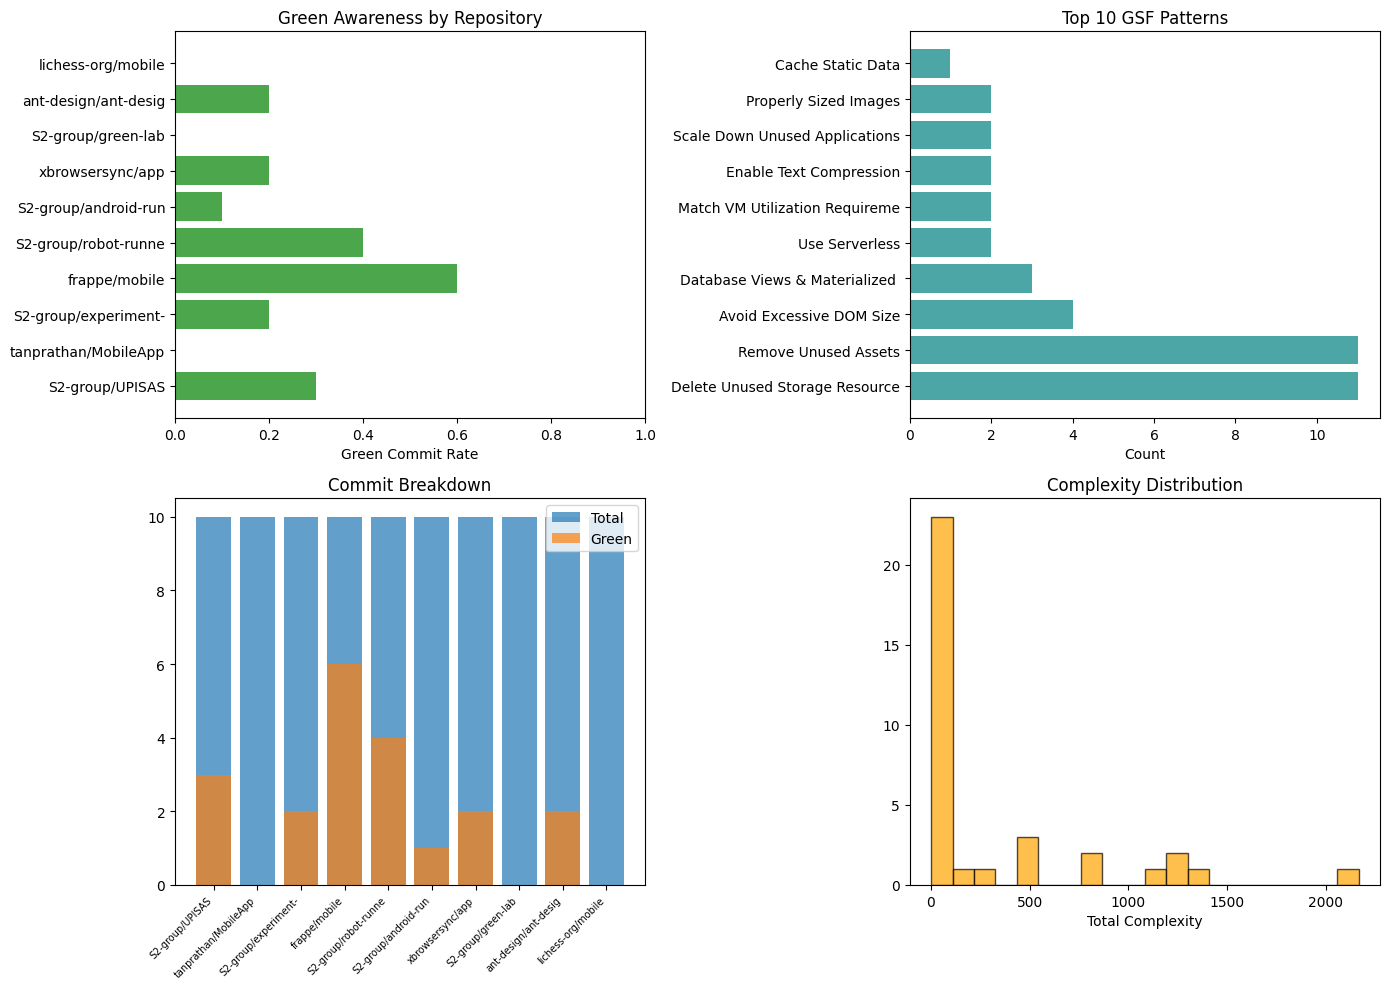

Saved to data/analysis_plots.png


In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Green commit rate per repository
repo_names = [r["name"][:20] for r in results]
green_rates = [r["green_commit_rate"] for r in results]
axes[0, 0].barh(repo_names, green_rates, color="green", alpha=0.7)
axes[0, 0].set_xlabel("Green Commit Rate")
axes[0, 0].set_title("Green Awareness by Repository")
axes[0, 0].set_xlim(0, 1)

# 2. Top 10 patterns
if sorted_patterns:
    top = sorted_patterns[:10]
    axes[0, 1].barh([p[0][:30] for p in top], [p[1] for p in top], color="teal", alpha=0.7)
    axes[0, 1].set_xlabel("Count")
    axes[0, 1].set_title("Top 10 GSF Patterns")

# 3. Commits breakdown
commit_counts = [r["total_commits"] for r in results]
green_counts = [r["green_commits"] for r in results]
x = range(len(results))
axes[1, 0].bar(x, commit_counts, label="Total", alpha=0.7)
axes[1, 0].bar(x, green_counts, label="Green", alpha=0.7)
axes[1, 0].set_xticks(list(x))
axes[1, 0].set_xticklabels(repo_names, rotation=45, ha="right", fontsize=7)
axes[1, 0].set_title("Commit Breakdown")
axes[1, 0].legend()

# 4. Complexity distribution
cxs = [c.get("total_complexity", 0) for c in all_commits if c.get("total_complexity")]
if cxs:
    axes[1, 1].hist(cxs, bins=20, color="orange", alpha=0.7, edgecolor="black")
    axes[1, 1].set_xlabel("Total Complexity")
    axes[1, 1].set_title("Complexity Distribution")

plt.tight_layout()
plt.savefig("data/analysis_plots.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved to data/analysis_plots.png")

---
## Step 15: Interactive Visualization (Plotly)

Interactive charts for deeper exploration.

In [16]:
import plotly.express as px
import warnings

# Suppress the FutureWarning from Plotly/Pandas compatibility
warnings.filterwarnings("ignore", category=FutureWarning, module="plotly")

# Sunburst: Repository -> Green/Non-Green -> Pattern
sun_data = []
for r in results:
    for c in r.get("commits", []):
        is_green = c.get("green_aware", False)
        cat = "Green" if is_green else "Non-Green"
        patterns = c.get("gsf_patterns_matched", [])
        # Use descriptive label instead of "None"
        if patterns:
            pat = patterns[0][:30]
        else:
            pat = "(No Pattern)" if is_green else "(Standard Commit)"
        sun_data.append(
            {
                "repository": r["name"][:20],
                "category": cat,
                "pattern": pat,
                "count": 1,
            }
        )

if sun_data:
    df_sun = pd.DataFrame(sun_data)
    fig = px.sunburst(
        df_sun,
        path=["repository", "category", "pattern"],
        values="count",
        title="Repository Analysis Breakdown",
        color="category",
        color_discrete_map={"Green": "#2ecc71", "Non-Green": "#e74c3c"},
    )
    fig.update_layout(margin=dict(t=50, l=0, r=0, b=0))
    fig.show()

# Scatter: Complexity vs NLOC
sc = [
    {
        "cx": c["total_complexity"],
        "nloc": c["total_nloc"],
        "green": "Green" if c.get("green_aware") else "Non-Green",
        "repo": c.get("repository", "Unknown"),
    }
    for c in all_commits
    if c.get("total_complexity") and c.get("total_nloc")
]

if sc:
    fig2 = px.scatter(
        pd.DataFrame(sc),
        x="nloc",
        y="cx",
        color="green",
        hover_data=["repo"],
        color_discrete_map={"Green": "#2ecc71", "Non-Green": "#e74c3c"},
        title="Complexity vs Lines of Code",
        labels={"nloc": "Lines of Code (NLOC)", "cx": "Cyclomatic Complexity"},
    )
    fig2.update_traces(marker=dict(size=8, opacity=0.7))
    fig2.show()

---
## Step 16: Export Results

Export the unified analysis to JSON, CSV, and pandas DataFrame.

In [17]:
import os

os.makedirs("data/features", exist_ok=True)

# 1. COMMITS BASIC INFO (lightweight, no source code)

commits_basic = []
for c in all_commits:
    commits_basic.append(
        {
            "repository": c.get("repository"),
            "commit_hash": c.get("commit_hash"),
            "author": c.get("author"),
            "date": c.get("date"),
            "message": str(c.get("message", ""))[:200],
            "files_modified": len(c.get("files_modified", []))
            if isinstance(c.get("files_modified"), list)
            else c.get("files_modified", 0),
            "insertions": c.get("insertions", 0),
            "deletions": c.get("deletions", 0),
        }
    )
with open("data/features/commits_basic.json", "w") as f:
    json.dump(commits_basic, f, indent=2, default=str)
print(f"commits_basic.json - {len(commits_basic)} commits")

# 2. GSF PATTERNS (green awareness detection results)
gsf_results = []
for c in all_commits:
    gsf_results.append(
        {
            "repository": c.get("repository"),
            "commit_hash": c.get("commit_hash"),
            "green_aware": c.get("green_aware", False),
            "gsf_patterns_matched": c.get("gsf_patterns_matched", []),
            "pattern_count": c.get("pattern_count", 0),
            "confidence": c.get("confidence", ""),
        }
    )
with open("data/features/gsf_patterns.json", "w") as f:
    json.dump(gsf_results, f, indent=2, default=str)
print(f"gsf_patterns.json - GSF pattern detection results")

# 3. PROCESS METRICS (DMM scores)
process_metrics = []
for c in all_commits:
    if any(
        c.get(k) is not None
        for k in ["dmm_unit_size", "dmm_unit_complexity", "dmm_unit_interfacing"]
    ):
        process_metrics.append(
            {
                "repository": c.get("repository"),
                "commit_hash": c.get("commit_hash"),
                "dmm_unit_size": c.get("dmm_unit_size"),
                "dmm_unit_complexity": c.get("dmm_unit_complexity"),
                "dmm_unit_interfacing": c.get("dmm_unit_interfacing"),
            }
        )
with open("data/features/process_metrics.json", "w") as f:
    json.dump(process_metrics, f, indent=2, default=str)
print(f"process_metrics.json - {len(process_metrics)} commits with DMM metrics")

# 4. COMPLEXITY METRICS (NLOC, cyclomatic complexity)

complexity_metrics = []
for c in all_commits:
    if c.get("total_nloc") or c.get("total_complexity"):
        complexity_metrics.append(
            {
                "repository": c.get("repository"),
                "commit_hash": c.get("commit_hash"),
                "total_nloc": c.get("total_nloc"),
                "total_complexity": c.get("total_complexity"),
                "max_complexity": c.get("max_complexity"),
                "methods_count": c.get("methods_count"),
            }
        )
with open("data/features/complexity_metrics.json", "w") as f:
    json.dump(complexity_metrics, f, indent=2, default=str)
print(f"complexity_metrics.json - {len(complexity_metrics)} commits with complexity data")


# 5. METHOD-LEVEL ANALYSIS (per-function metrics from Lizard)
method_analysis = []
for c in all_commits:
    methods = c.get("methods", [])
    if methods:
        method_analysis.append(
            {
                "repository": c.get("repository"),
                "commit_hash": c.get("commit_hash"),
                "methods": methods,  # List of {name, nloc, complexity, ...}
            }
        )
with open("data/features/method_analysis.json", "w") as f:
    json.dump(method_analysis, f, indent=2, default=str)
print(f"method_analysis.json - {len(method_analysis)} commits with method-level data")

# 6. SOURCE CODE CHANGES (before/after file content)
source_changes = []
for c in all_commits:
    changes = c.get("source_changes", [])
    if changes:
        source_changes.append(
            {
                "repository": c.get("repository"),
                "commit_hash": c.get("commit_hash"),
                "source_changes": changes,  # List of {filename, source_code_before, source_code_after, diff, ...}
            }
        )
with open("data/features/source_code_changes.json", "w") as f:
    json.dump(source_changes, f, indent=2, default=str)
size_mb = os.path.getsize("data/features/source_code_changes.json") / (1024 * 1024)
print(f"source_code_changes.json - {len(source_changes)} commits ({size_mb:.1f} MB)  E")

# 7. ENERGY METRICS (if energy_tracking was enabled)
energy_metrics = []
for c in all_commits:
    if c.get("energy_joules") or c.get("energy_watts_avg"):
        energy_metrics.append(
            {
                "repository": c.get("repository"),
                "commit_hash": c.get("commit_hash"),
                "energy_joules": c.get("energy_joules"),
                "energy_watts_avg": c.get("energy_watts_avg"),
            }
        )
with open("data/features/energy_metrics.json", "w") as f:
    json.dump(energy_metrics, f, indent=2, default=str)
print(f"energy_metrics.json - {len(energy_metrics)} commits with energy data")

# 8. REPOSITORY SUMMARY (high-level stats per repo)

repo_summary = []
for r in results:
    repo_summary.append(
        {
            "name": r["name"],
            "url": r["url"],
            "total_commits": r["total_commits"],
            "green_commits": r["green_commits"],
            "green_commit_rate": r["green_commit_rate"],
            "process_metrics": r.get("process_metrics", {}),
            "energy_metrics": r.get("energy_metrics"),
        }
    )
with open("data/features/repository_summary.json", "w") as f:
    json.dump(repo_summary, f, indent=2, default=str)
print(f"repository_summary.json - {len(repo_summary)} repositories")


# 9. CSV FOR SPREADSHEET ANALYSIS

csv_rows = []
for c in all_commits:
    csv_rows.append(
        {
            "repository": c.get("repository"),
            "commit_hash": c.get("commit_hash"),
            "author": c.get("author"),
            "date": c.get("date"),
            "green_aware": c.get("green_aware", False),
            "patterns_matched": ", ".join(c.get("gsf_patterns_matched", [])),
            "pattern_count": c.get("pattern_count", 0),
            "files_modified": len(c.get("files_modified", []))
            if isinstance(c.get("files_modified"), list)
            else c.get("files_modified", 0),
            "insertions": c.get("insertions", 0),
            "deletions": c.get("deletions", 0),
            "dmm_unit_size": c.get("dmm_unit_size"),
            "dmm_unit_complexity": c.get("dmm_unit_complexity"),
            "total_nloc": c.get("total_nloc"),
            "total_complexity": c.get("total_complexity"),
        }
    )
df_export = pd.DataFrame(csv_rows)
df_export.to_csv("data/features/all_commits.csv", index=False)
print(f"all_commits.csv - {len(csv_rows)} rows")


# SUMMARY

print("\n" + "=" * 60)
print("EXPORT COMPLETE - Each feature saved separately:")
print("=" * 60)
for f in sorted(os.listdir("data/features")):
    path = f"data/features/{f}"
    size = os.path.getsize(path)
    if size > 1024 * 1024:
        print(f"  {f}: {size / (1024 * 1024):.1f} MB")
    else:
        print(f"  {f}: {size / 1024:.1f} KB")

commits_basic.json - 100 commits
gsf_patterns.json - GSF pattern detection results
process_metrics.json - 30 commits with DMM metrics
complexity_metrics.json - 36 commits with complexity data
method_analysis.json - 35 commits with method-level data
source_code_changes.json - 0 commits (0.0 MB)  E
energy_metrics.json - 0 commits with energy data
repository_summary.json - 10 repositories
all_commits.csv - 100 rows

EXPORT COMPLETE - Each feature saved separately:
  all_commits.csv: 14.5 KB
  commits_basic.json: 31.4 KB
  complexity_metrics.json: 7.6 KB
  energy_metrics.json: 0.0 KB
  gsf_patterns.json: 23.9 KB
  method_analysis.json: 1.6 MB
  process_metrics.json: 6.3 KB
  repository_summary.json: 2.6 MB
  source_code_changes.json: 0.0 KB


---
# Summary
 
## Repositories Analyzed
- 10 mobile app repositories (GraphQL search)
- 5 S2-group repositories (Green-lab, UPISAS, Experiment-runner, Robot-runner, Android-runner)
- **Total: 15 repositories**

## Features & Output Files

Each feature is saved in its own file under `data/features/`:

| File | Feature | What It Contains |
|------|---------|------------------|
| `commits_basic.json` | Basic commit info | hash, author, date, message, files changed |
| `gsf_patterns.json` | GSF Pattern Detection | green_aware, patterns matched, confidence |
| `process_metrics.json` | DMM Metrics | dmm_unit_size, dmm_unit_complexity, dmm_unit_interfacing |
| `complexity_metrics.json` | Code Complexity | total_nloc, total_complexity, max_complexity |
| `method_analysis.json` | Method-Level Analysis | per-function metrics from Lizard |
| `source_code_changes.json` | Source Code Capture | **LARGE** - full file before/after each change |
| `energy_metrics.json` | Energy Measurement | joules, watts (if energy_tracking=True) |
| `repository_summary.json` | Repo Overview | stats per repository |
| `all_commits.csv` | Spreadsheet Export | flattened data for Excel/Sheets |

 